In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import concurrent.futures
from scipy.special import erf
import time

In [2]:
# Large Mass Model of D_\inf with a Gaussian Noise Assumption

def gauss_field_mean(stake, f):
    D0 = stake.sum()
    D02 = (stake**2).sum()
    return D0/2 + np.sqrt(D0**2 + 2*D02*np.log(1 - f))/2;

def gauss_field_var(stake, f, delta, T):
    D0 = stake.sum()
    D02 = (stake**2).sum()
    ED = gauss_field_mean(stake, f)
    return delta*(2*D0*ED + 3*D02*np.log(1 - f))*ED**2/(2*D0*T*(D0*delta*np.log(1 - f) + ED**2));

In [3]:
from dataclasses import dataclass

def phi(f, alpha):
    return 1 - (1-f)**alpha

@dataclass
class Params:
    epochs: int
    sims: int
    stake: np.array
    T: int
    f: float
    beta: float
    D_init: float

    @property
    def h_at_fixpoint(self):
        D_inf = gauss_field_mean(f=self.f, stake=self.stake)
        return D_inf / np.log(1/(1-self.f)) * self.beta
    
    def __str__(self):
        import dataclasses
        """Returns a string containing only the non-default field values."""
        s = ', '.join(f'{field.name}={getattr(self, field.name)!r}'
                      for field in dataclasses.fields(self)
                      if field.name != "stake")
        s += f", stake=(N={len(self.stake)}, mean={self.stake.mean():.2f}, var={self.stake.var():.2f})"
        return f'{type(self).__name__}({s})'
    

@dataclass
class EmpiricalResult:
    seed: int
    D: np.array
    leader_rate: np.array


def sim_empirical(params: Params, seed=None):
    if seed is not None:
        np.random.seed(seed)
    D = np.zeros((params.sims, params.epochs + 1)) # D values evolved across time for each simulation
    D[:,0] = params.D_init
    leader_rate = np.zeros((params.sims, params.epochs)) # How many leaders were observed / slot for each epoch

    stake_per_sim = np.repeat(params.stake, params.sims).reshape((len(params.stake), params.sims)).transpose()

    start = time.time()
    info_rate = 1000
    for epoch in range(params.epochs):
        if epoch > 0 and epoch % info_rate == 0:
            elapsed = time.time() - start
            per_epoch = elapsed / epoch
            estimate = per_epoch * params.epochs
            print("epoch=",epoch,"of",params.epochs, f"eta={estimate-elapsed:.2f}s", f"{info_rate} epochs={info_rate*per_epoch:.2f}s")
    
        D_t = D[:,epoch]
        D_per_stake = np.repeat(D_t, len(params.stake)).reshape((params.sims, len(params.stake)))
        relative_stake = stake_per_sim / D_per_stake
        bias = phi(params.f, relative_stake)

        # bias (# of paths, # of nodes)
        
        leader_rate[:,epoch] = np.random.binomial(params.T, bias).sum(axis=1) / params.T
        error = np.log(1/(1-params.f)) - leader_rate[:,epoch]
        h = D_t / np.log(1/(1-params.f)) * params.beta
        correction = h * error
        D[:,epoch+1] = np.maximum(D_t - correction, np.zeros(params.sims) + 1e-6)

    return EmpiricalResult(
        seed=seed,
        D=D[:,:params.epochs],
        leader_rate=leader_rate
    )

In [4]:
# This simulation runs our models derived in overleaf, the numerical results can later be compared against the empirical results above

@dataclass
class NumericalResult():
    D: np.array
    D_var: np.array
    leader_rate: np.array
    leader_rate_var: np.array
    
def sim_numerical(params: Params):
    D = np.zeros(params.epochs + 1)
    D[0] = params.D_init
    D_var = np.zeros(params.epochs + 1)
    leader_rate = np.zeros(params.epochs)
    leader_rate_var = np.zeros(params.epochs)
    
    start = time.time()
    info_rate = 10000
    for epoch in range(params.epochs):
        if epoch > 0 and epoch % info_rate == 0:
            elapsed = time.time() - start
            per_epoch = elapsed / epoch
            estimate = per_epoch * params.epochs
            print("epoch=",epoch,"of",params.epochs, f"eta={estimate-elapsed:.2f}s", f"{info_rate} epochs={info_rate*per_epoch:.2f}s")
    
        D_t = D[epoch]
        relative_stake = params.stake / D_t
        phi_outcomes = phi(params.f, relative_stake)
        leader_rate[epoch] = phi_outcomes.sum()
        error = np.log(1/(1-params.f)) - leader_rate[epoch]
        h = D_t / np.log(1/(1-params.f)) * params.beta
        correction = h * error
        D[epoch+1] = np.maximum(D_t - correction, 1e-6)
        D_var[epoch+1] = h**2 *  (phi_outcomes * (1 - phi_outcomes)).sum() / params.T
        leader_rate_var[epoch] = (phi_outcomes * (1 - phi_outcomes)).sum() / params.T
    return NumericalResult(
        D=D[:params.epochs],
        D_var=D_var[:params.epochs],
        leader_rate=leader_rate,
        leader_rate_var=leader_rate_var,
    )

In [5]:
# Helper for driving hyper-parameter analysis
def run_empirical_sims(params, seed=lambda i: 0):
    def driver(pair):
        i, p = pair
        print(f"Started {i + 1} / {len(params)}")
        result = sim_empirical(p, seed=seed(i))
        print(f"Finished {i + 1} / {len(params)}")
        return result

    with concurrent.futures.ThreadPoolExecutor(max_workers=50) as executor:
        results = list(executor.map(driver, enumerate(params)))
    return results

In [6]:
def boltzmann_D_mean_v2(beta, stake, f):
    D0 = stake.sum()
    D02 = (stake**2).sum()
    
    a = D0/2 + np.sqrt(D0**2 + 2*D02*np.log(1 - f))/2
    A = (-np.log(1 - f)*D0/(2*a**2) - D02*np.log(1 - f)**2/(2*a**3))

    # num =     sqrt(Pi)*a*erf(A*a*beta/sqrt(A*beta))*A*beta + a*sqrt(Pi)*A*beta + exp(-A*a^2*beta)*sqrt(A*beta)
    numerator = np.sqrt(np.pi)*a*erf(A*a*beta/np.sqrt(A*beta))*A*beta + a*np.sqrt(np.pi)*A*beta + np.exp(-A*a**2*beta)*np.sqrt(A*beta)
    # denum = A*beta*sqrt(Pi)*(1 + erf(A*a*beta/sqrt(A*beta)))
    denominator = A*beta*np.sqrt(np.pi)*(1 + erf(A*a*beta/np.sqrt(A*beta)))

    result = numerator / denominator
    return result

def boltzmann_D_var_v2(beta, stake, f):
    D0 = stake.sum()
    D02 = (stake**2).sum()

    # a := D0/2 + sqrt(D0^2 + 2*D02*ln(1 - f))/2;
    a = D0/2 + np.sqrt(D0**2 + 2*D02*np.log(1 - f))/2

    # A:=(-ln(1 - f)*D0/(2*a^2) - D02*ln(1 - f)^2/(2*a^3));
    A = (-np.log(1 - f)*D0/(2*a**2) - D02*np.log(1 - f)**2/(2*a**3))

    numerator = (-2*np.sqrt(A*beta)*erf(A*a*beta/np.sqrt(A*beta))*np.exp(-A*a**2*beta)*np.pi*a +
                 np.pi**(3/2)*erf(A*a*beta/np.sqrt(A*beta))**2 -
                 2*np.sqrt(A*beta)*np.exp(-A*a**2*beta)*np.pi*a +
                 2*np.pi**(3/2)*erf(A*a*beta/np.sqrt(A*beta)) -
                 2*np.sqrt(np.pi)*np.exp(-2*A*a**2*beta) +
                 np.pi**(3/2))

    denominator = 2*A*beta*np.pi**(3/2)*(1 + erf(A*a*beta/np.sqrt(A*beta)))**2
    result = numerator / denominator
    return result

def large_mass_mean(f, Ew, Vw, N):
    return Ew*N/2 + np.sqrt((N*Ew)**2  - 2*(Ew**2*N + Vw*(N-1))*np.log(1/(1-f)))/2

def large_mass_var(f, Ew, Vw, N, T, delta):
    D_infty = large_mass_mean(f, Ew, Vw, N)
    num = D_infty**2*delta*(2*D_infty*Ew*N-3*(Ew**2*N + Vw*(N-1))*np.log(1/(1-f)))
    denum = 2*Ew*N*T*(D_infty**2 - Ew*N*delta*np.log(1/(1-f)))
    return num / denum

def plot(params, empirical, numerical):
    x_epochs = np.array(range(params.epochs))
    
    D_true = params.stake.sum()
    XX = 10000000
    leader_rate_true = (np.random.binomial(XX, phi(params.f, params.stake / D_true)) / XX).sum()
    
    leader_rate_mean = empirical.leader_rate.mean(axis=0)
    leader_rate_std = np.sqrt(empirical.leader_rate.var(axis=0))
    
    D_ratio = empirical.D/D_true
    D_ratio_mean = D_ratio.mean(axis=0)
    D_ratio_std = np.sqrt(empirical.D.var(axis=0)) / D_true
    
    d_sq_err = np.abs(empirical.D - D_true) ** 2
    d_sq_err_mean = d_sq_err.mean(axis=0)
    d_sq_err_std = np.sqrt(d_sq_err.var(axis=0))
    

    numerical_D_ratio = numerical.D/D_true
    numerical_D_ratio_std = np.sqrt(numerical.D_var) / D_true
    
    
    plt.figure(figsize=(16,10), dpi=120)
    ax_leaders = plt.subplot(321)
    ax_leaders.set_title("observed leader rate")
    ax_leaders.set_xlabel("epochs")
    ax_leaders.set_ylabel("leaders/slot")
    ax_leaders.vlines(x_epochs, ymin=leader_rate_mean - leader_rate_std, ymax=leader_rate_mean + leader_rate_std, colors="lightgray", label="std")
    ax_leaders.plot(x_epochs, leader_rate_mean, c="k",linewidth=1,  label="mean")
    ax_leaders.plot(x_epochs, x_epochs * 0 + leader_rate_true, c="red", label="optimal leader rate")
    ax_leaders.plot(x_epochs, x_epochs * 0 + np.log(1 / (1-params.f)), c="blue", label="leader rate upper target")
    ax_leaders.plot(x_epochs, numerical.leader_rate, c="orange", label="numerical")
    ax_leaders.legend()
    
    ax_leader_var = plt.subplot(322)
    ax_leader_var.set_title("Leader rate variance")
    ax_leader_var.plot(x_epochs, leader_rate_std **2, color="k", label="empirical")
    ax_leader_var.plot(x_epochs, numerical.leader_rate_var, color="orange", label="numerical $\Delta=0$")
    ax_leader_var.legend()
    
    ax_D = plt.subplot(323)
    ax_D.set_title("$E[D/D^0]$")
    ax_D.set_xlabel("epochs")
    ax_D.set_ylabel("$D/D^0$")
    ax_D.plot(x_epochs, D_ratio_mean, c="k", linewidth=1, label="D_ratio")
    ax_D.plot(x_epochs, numerical_D_ratio, c="orange", linewidth=2, label="numerical $\Delta=0$")
    ax_D.plot(x_epochs, np.ones(params.epochs), c="red", label="D_true")
    ax_D.plot(x_epochs, np.zeros(params.epochs) + np.log(1-params.f) / np.log(1-np.log(1/(1-params.f))), c="blue", label="lower-bound")
    ax_D.plot(x_epochs, np.zeros(params.epochs) + gauss_field_mean(f=params.f, stake=params.stake) / D_true, label="large mass model")
    ax_D.legend()
    
    ax_D_var = plt.subplot(324)
    ax_D_var.set_title("Var[D]")
    ax_D_var.plot(x_epochs, empirical.D.var(axis=0), color="k", label="empirical")
    ax_D_var.legend()

    ax_D2 = plt.subplot(313)
    ax_D2.set_title("($D_\ell - D^0)^2$")
    ax_D2.set_xlabel("epochs")
    ax_D2.set_ylabel("squared error")
    ax_D2.vlines(x_epochs,
                 ymin=np.maximum(np.zeros(params.epochs), (d_sq_err_mean - d_sq_err_std)),
                 ymax=(d_sq_err_mean + d_sq_err_std),
                 colors="lightgray",
                 label="std"
                )
    ax_D2.plot(x_epochs, d_sq_err_mean, c="k", linewidth=3, label="squared error")
    ax_D2.plot(x_epochs, ((numerical.D_var + (numerical.D - D_true)**2)), c="orange", label="numerical $\Delta=0$")
    ax_D2.set_ylim((0, None))
    ax_D2.legend()

    plt.tight_layout()

    print(str(params), f"whale={params.stake.max() / params.stake.sum() * 100:.2f}%")

<>:84: SyntaxWarning: invalid escape sequence '\D'
<>:92: SyntaxWarning: invalid escape sequence '\D'
<>:104: SyntaxWarning: invalid escape sequence '\e'
<>:114: SyntaxWarning: invalid escape sequence '\D'
<>:84: SyntaxWarning: invalid escape sequence '\D'
<>:92: SyntaxWarning: invalid escape sequence '\D'
<>:104: SyntaxWarning: invalid escape sequence '\e'
<>:114: SyntaxWarning: invalid escape sequence '\D'
/private/tmp/nix-shell-78445-0/ipykernel_80506/763334158.py:84: SyntaxWarning: invalid escape sequence '\D'
  ax_leader_var.plot(x_epochs, numerical.leader_rate_var, color="orange", label="numerical $\Delta=0$")
/private/tmp/nix-shell-78445-0/ipykernel_80506/763334158.py:92: SyntaxWarning: invalid escape sequence '\D'
  ax_D.plot(x_epochs, numerical_D_ratio, c="orange", linewidth=2, label="numerical $\Delta=0$")
/private/tmp/nix-shell-78445-0/ipykernel_80506/763334158.py:104: SyntaxWarning: invalid escape sequence '\e'
  ax_D2.set_title("($D_\ell - D^0)^2$")
/private/tmp/nix-shell-

Params(epochs=100, sims=1000, T=432000, f=0.05, beta=0.5, D_init=np.float64(12365.651688404821), stake=(N=1000, mean=12.37, var=30208.31)) whale=42.24%


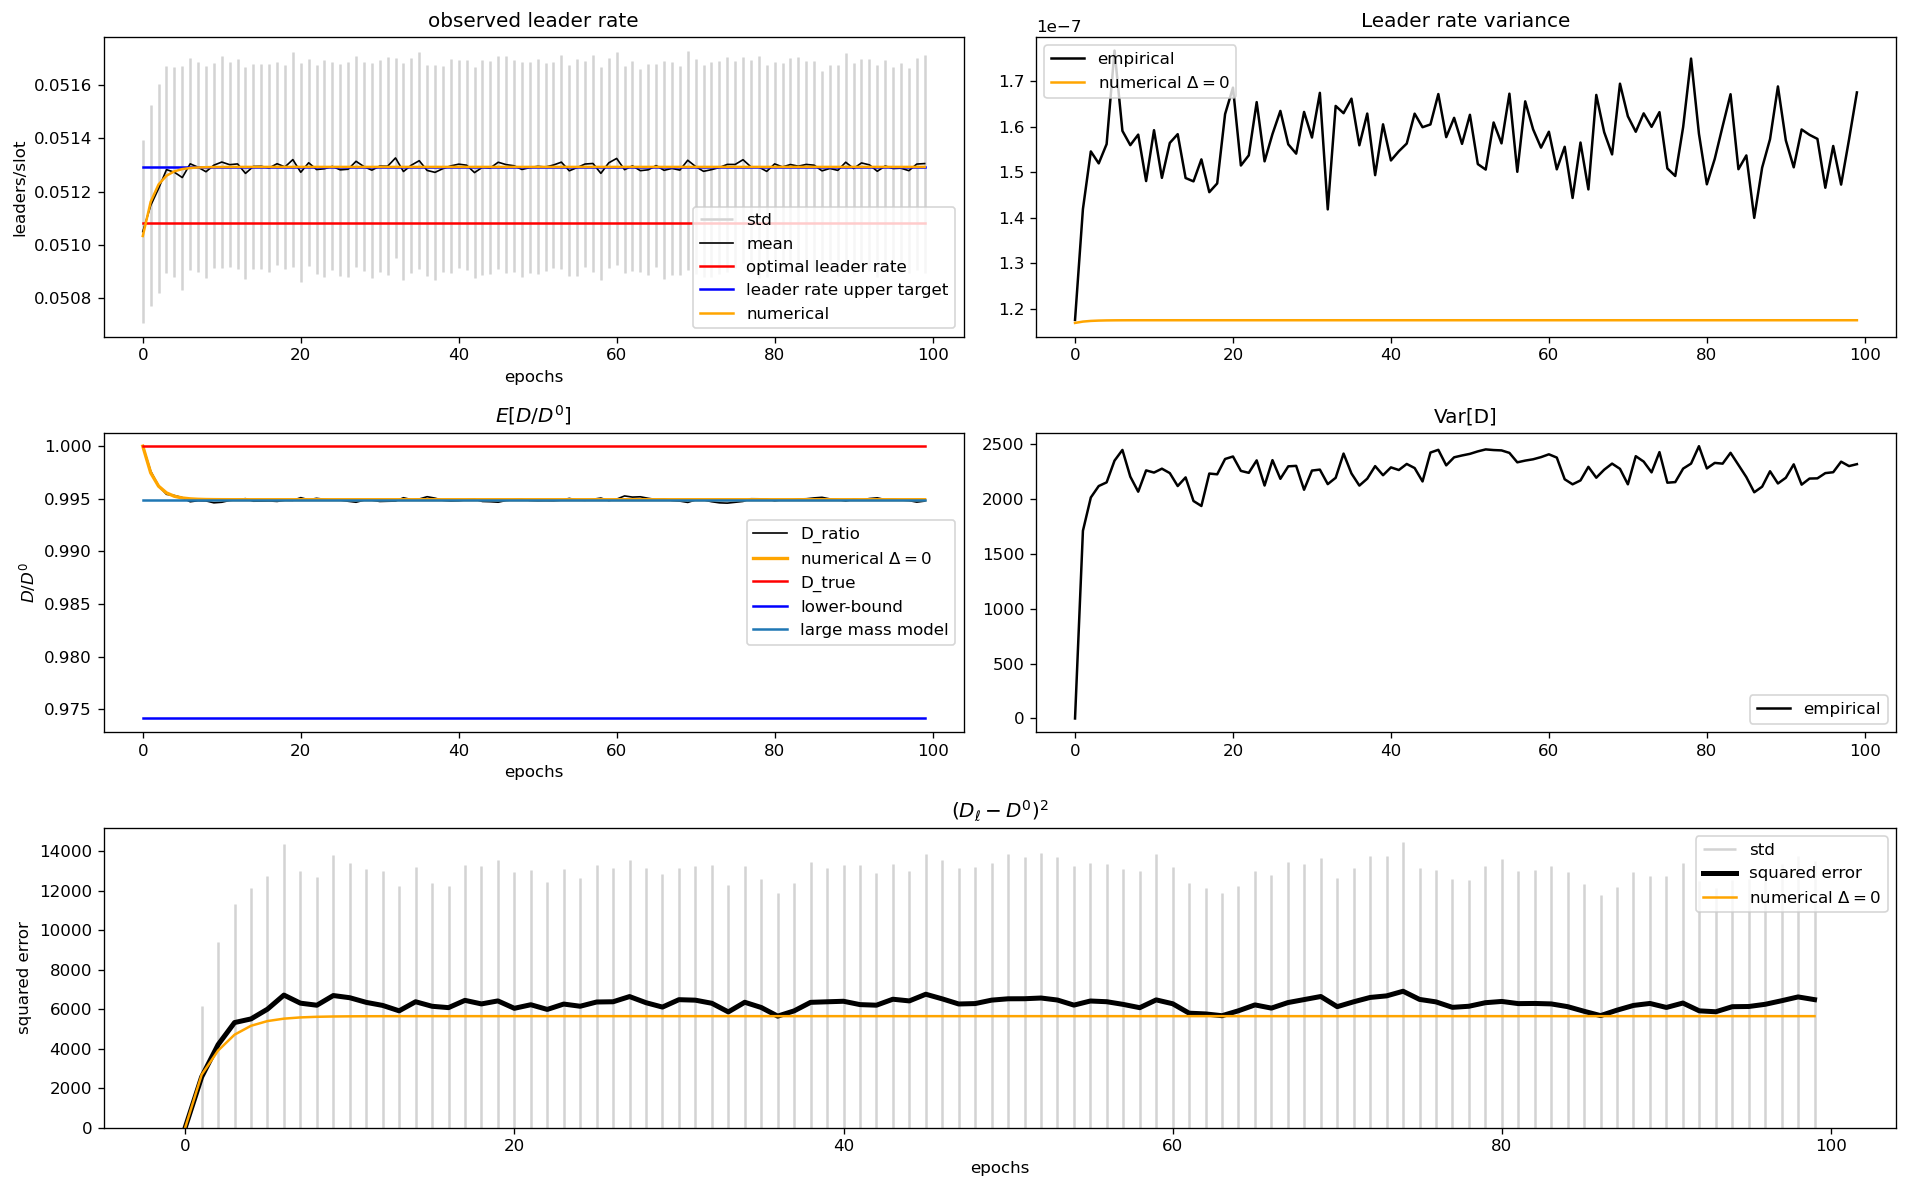

In [7]:
N = 1000
np.random.seed(0)
stake = np.random.pareto(1, N)
f=0.05
params = Params(
    epochs=100,
    sims=1000,
    stake=stake,
    D_init=stake.sum(), # analysis when initial estimate D_0 is total stake
    T=60 * 60 * 24 * 5, # 5 days at 1 second slots
    f=f,
    beta=0.5,
)

empirical_results = sim_empirical(params)
numerical_results = sim_numerical(params)

plot(params, empirical_results, numerical_results)

# Study Behaviour as $T$ (epoch length) is Varied

In [8]:
np.random.seed(0)
evaluations = 100
N = 1000
stake = np.random.pareto(5, N)
params = [Params(
    epochs=100,
    sims=100,
    stake=stake,
    D_init=stake.sum(),
    T=60*60*24*5*((i+1)/evaluations),
    f=0.05,
    beta=0.8,
) for i in range(evaluations)]

In [ ]:
empirical_results = run_empirical_sims(params)

Started 1 / 100
Started 2 / 100
Started 3 / 100
Started 4 / 100
Started 5 / 100
Started 6 / 100
Started 7 / 100
Started 8 / 100
Started 9 / 100
Started 10 / 100
Started 11 / 100
Started 12 / 100
Started 13 / 100
Started 14 / 100
Started 15 / 100
Started 16 / 100
Started 17 / 100
Started 18 / 100
Started 19 / 100
Started 20 / 100
Started 21 / 100
Started 22 / 100
Started 23 / 100
Started 24 / 100
Started 25 / 100
Started 26 / 100
Started 27 / 100
Started 28 / 100
Started 29 / 100
Started 30 / 100
Started 31 / 100
Started 32 / 100
Started 33 / 100
Started 34 / 100
Started 35 / 100
Started 36 / 100
Started 37 / 100
Started 38 / 100
Started 39 / 100
Started 40 / 100
Started 41 / 100
Started 42 / 100
Started 43 / 100
Started 44 / 100
Started 45 / 100
Started 46 / 100
Started 47 / 100
Started 48 / 100
Started 49 / 100
Started 50 / 100


In [ ]:
numerical_results = [sim_numerical(p) for p in params]

In [ ]:
plot(params[-1], empirical_results[-1], numerical_results[-1])

In [ ]:
skip_epochs = 20
empirical_D_mean = [r.D[:,skip_epochs:].flatten().mean() for r in empirical_results]
empirical_D_var = [r.D[:,skip_epochs:].flatten().var(axis=0) for r in empirical_results]
T = [p.T for p in params]
numerical_D_mean = [r.D[skip_epochs:].mean() for r in numerical_results]
numerical_var = [r.D_var[skip_epochs:].mean() for r in numerical_results]
empirical_leader_var = [r.leader_rate[:,skip_epochs:].flatten().var() for r in empirical_results]
numerical_leader_var = [r.leader_rate_var[skip_epochs:].mean() for r in numerical_results]
gauss_mean = [gauss_field_mean(stake=p.stake, f=p.f) for p in params]
gauss_var = [gauss_field_var(stake=p.stake, f=p.f, delta=p.h_at_fixpoint, T=p.T) for p in params]

plt.figure(figsize=(16,8), dpi=120)
D_var_vs_T = plt.subplot(221)
_ = D_var_vs_T.set_title("$Var[D]$ vs. T")
_ = D_var_vs_T.set_ylabel("$Var[D]$")
_ = D_var_vs_T.set_xlabel("T")
_ = D_var_vs_T.plot(T, empirical_D_var, c="k", label="empirical")
_ = D_var_vs_T.plot(T, gauss_var, c="red", label="gauss")
_ = D_var_vs_T.legend()

D_var_vs_leader_var = plt.subplot(222)
D_var_vs_leader_var.set_title("Var$\\left[\sum s_i\\right]$ vs T")
D_var_vs_leader_var.set_ylabel("Var$\\left[\sum s_i\\right]$")
_ = D_var_vs_leader_var.set_xlabel("T")
_ = D_var_vs_leader_var.plot(T, empirical_leader_var, c="k", label="empirical", linewidth=3)
_ = D_var_vs_leader_var.plot(T, numerical_leader_var, c="orange", label="$\\Delta = 0$", linewidth=1)
_ = D_var_vs_leader_var.legend()

D_mean_vs_T = plt.subplot(223)
D_mean_vs_T.set_title("E$\\left[D\\right]$ vs T")
D_mean_vs_T.set_ylabel("E$\\left[D\\right]$")
_ = D_mean_vs_T.set_xlabel("T")
_ = D_mean_vs_T.plot(T, empirical_D_mean, c="k", label="empirical")
_ = D_mean_vs_T.plot(T, numerical_D_mean, c="orange", label="numerical")
_ = D_mean_vs_T.plot(T, gauss_mean, color="red", label="gauss")
_ = D_mean_vs_T.legend()

plt.tight_layout()
print(params[0])

In [ ]:
evaluations = 100
def make_params(i):
    np.random.seed(0)
    N = 100
    stake = np.random.uniform(0, 1, N) ** (i*2+1)
    return Params(
        epochs=70,
        sims=10,
        stake = stake,
        D_init = stake.sum(),
        T=60*60*24*5,
        f=0.05,
        beta=0.5,
    )

vary_stake_params = [make_params(i) for i in range(evaluations)]

In [ ]:
vary_stake_empirical_results = run_empirical_sims(vary_stake_params)

In [ ]:
vary_stake_numerical_results = [sim_numerical(p) for p in vary_stake_params]

In [ ]:
@interact(i=(0,len(vary_stake_params)-1))
def polt_i(i):
    plot(vary_stake_params[i], empirical=vary_stake_empirical_results[i], numerical=vary_stake_numerical_results[i])

In [ ]:
skip_first_epochs = 10
D_true = np.array([p.stake.sum() for p in vary_stake_params])
empirical_D_mean = [r.D[:,skip_first_epochs:].flatten().mean() for r in vary_stake_empirical_results]
empirical_D_var = [r.D[:,skip_first_epochs:].flatten().var() for r in vary_stake_empirical_results]
numerical_D_mean = [r.D[:skip_first_epochs].mean() for r in vary_stake_numerical_results]
numerical_D_var = [r.D[:skip_first_epochs].var() for r in vary_stake_numerical_results]
w_mean = [p.stake.mean() for p in vary_stake_params]
w_var = [(p.stake/p.stake.sum()).var() for p in vary_stake_params]
gauss_mean_vary_stake = [gauss_field_mean(f=p.f, stake=p.stake) for p in vary_stake_params]
gauss_var_vary_stake = [gauss_field_var(f=p.f, stake=p.stake, delta=p.h_at_fixpoint, T=p.T) for p in vary_stake_params]

D_upper_bound = D_true
D_lower_bound = np.array([np.log(1-p.f)/np.log(1-np.log(1/(1-p.f))) * p.stake.sum() for p in vary_stake_params])

plt.figure(figsize=(16,8), dpi=120)
D_mean_vs_w_var = plt.subplot(221)
_ = D_mean_vs_w_var.set_title("E[D/D_true] vs Var[$\\alpha_i$]")
_ = D_mean_vs_w_var.set_ylabel("E[D/D_true]")
_ = D_mean_vs_w_var.set_xlabel("Var[$\\alpha_i$]")
_ = D_mean_vs_w_var.scatter(w_var, empirical_D_mean / D_true, color="k", label="empirical")
_ = D_mean_vs_w_var.scatter(w_var, gauss_mean_vary_stake / D_true, marker="x", color="C3", label="large mass model")
_ = D_mean_vs_w_var.plot(w_var, D_upper_bound / D_true, color="C4", label="D_upper_bound")
_ = D_mean_vs_w_var.plot(w_var, D_lower_bound / D_true, color="C5", label="D_lower_bound")
_ = D_mean_vs_w_var.legend()



D_var_vs_w_var = plt.subplot(222)
_ = D_var_vs_w_var.set_title("Var[D] vs Var[$\\alpha_i$]")
_ = D_var_vs_w_var.set_ylabel("Var[D]")
_ = D_var_vs_w_var.set_xlabel("Var[$\\alpha_i$]")
_ = D_var_vs_w_var.scatter(w_var, empirical_D_var, color="k", label="empirical")
_ = D_var_vs_w_var.scatter(w_var, gauss_var_vary_stake, marker="x", color="C3", label="large mass")
_ = D_var_vs_w_var.set_yscale("log")
_ = D_var_vs_w_var.legend()


D_mean_vs_w_mean = plt.subplot(223)
_ = D_mean_vs_w_mean.set_title("E[D/D_true] vs E[$w_i$]")
_ = D_mean_vs_w_mean.set_ylabel("E[D/D_true]")
_ = D_mean_vs_w_mean.set_xlabel("E[$w_i$]")
_ = D_mean_vs_w_mean.scatter(w_mean, empirical_D_mean / D_true, color="k", label="empirical")
_ = D_mean_vs_w_mean.scatter(w_mean, gauss_mean_vary_stake / D_true, marker="x", color="C3", label="large mass model")
_ = D_mean_vs_w_mean.plot(w_mean, D_upper_bound / D_true, color="C4", label="D_upper_bound")
_ = D_mean_vs_w_mean.plot(w_mean, D_lower_bound / D_true, color="C5", label="D_lower_bound")
_ = D_mean_vs_w_mean.legend()



D_var_vs_w_var = plt.subplot(224)
_ = D_var_vs_w_var.set_title("Var[D] vs E[$w_i$]")
_ = D_var_vs_w_var.set_ylabel("Var[D]")
_ = D_var_vs_w_var.set_xlabel("E[$w_i$]")
_ = D_var_vs_w_var.scatter(w_mean, empirical_D_var, color="k", label="empirical")
_ = D_var_vs_w_var.scatter(w_mean, gauss_var_vary_stake, marker="x", color="C3", label="large mass model")
_ = D_var_vs_w_var.set_yscale("log")
_ = D_var_vs_w_var.set_xscale("log")
_ = D_var_vs_w_var.legend()

plt.tight_layout()
print(vary_stake_params[0])

# Verify that noise at fixpoint is Gaussian

In [ ]:
# Checking if D ~ Gaussian
def sim_d_gaussian():
    N = 1000
    stake = np.random.pareto(4, N)
    p = Params(
        epochs=20000,
        sims=1,
        stake = stake,
        D_init = stake.sum(),
        T=60*60*24*5,
        f=0.05,
        beta=0.5,
    )
    return sim_empirical(p), p

r, p = sim_d_gaussian()

In [ ]:
data = r.D[:, 1000:].flatten() # skip the first 1000 epochs to discard convergence time
from scipy import stats 
x_data = np.arange(data.min() * 0.999, data.max(), 0.1) 
## y-axis as the gaussian 
y_data = stats.norm.cdf(x_data, data.mean(), np.sqrt(data.var())) 

boltz_mean = boltzmann_D_mean_v2(beta=p.T, stake=p.stake, f=p.f)
boltz_var = boltzmann_D_var_v2(beta=p.T, stake=p.stake, f=p.f)
boltz_cdf = stats.norm.cdf(x_data, boltz_mean, np.sqrt(boltz_var))
gauss_mean = gauss_field_mean(stake=p.stake, f=p.f)
gauss_var = gauss_field_var(stake=p.stake, f=p.f, T=p.T, delta=p.h_at_fixpoint)
gauss_cdf = stats.norm.cdf(x_data, gauss_mean, np.sqrt(gauss_var))

plt.title("D distribution at fixed point")
_ = plt.hist(data, bins=100, cumulative=True, density=True)
_ = plt.plot(x_data, y_data, label="empirical fit")
_ = plt.plot(x_data, boltz_cdf, label="boltzman")
_ = plt.plot(x_data, gauss_cdf, label="large mass")
_ = plt.legend()
print(p)
print("large mass std", np.sqrt(gauss_var))
print("empirical std",  np.sqrt(data.var()))

# Stability Analysis

Stability Analysis shows we should have a stable fixed point when the following condition is met:

\begin{equation}
0<h\left[-\frac{\log(1-f)D^0[\{w_i\}]}{D_{\infty}^2} - \frac{D^0[\{w^2_i\}]\log(1-f)^2}{D_{\infty}^3}\right]<1
\end{equation}

Or written another way:

\begin{equation}
0< h < \frac{1}{-\frac{\log(1-f)D^0[\{w_i\}]}{D_{\infty}^2} - \frac{D^0[\{w^2_i\}]\log(1-f)^2}{D_{\infty}^3}}
\end{equation}


We can take $h$ to be $\beta\frac{D_\ell}{-\log(1-f)}$ and on inspection

\begin{equation}
0< h = \beta\frac{D_\ell}{-\log(1-f)} < \frac{1}{-\frac{\log(1-f)D^0[\{w_i\}]}{D_{\infty}^2} - \frac{D^0[\{w^2_i\}]\log(1-f)^2}{D_{\infty}^3}}
\end{equation}

holds for $\beta < 0.97$

In [ ]:
evaluations = 100
def make_params(i):
    np.random.seed(0)
    N = 500
    stake = np.random.pareto(5, N)
    f = 0.05
    beta = (i+1) / evaluations * 4
    return Params(
        epochs=2000,
        sims=10,
        stake = stake,
        D_init = stake.sum(),
        T=60*60*24*5,
        f=f,
        beta=beta,
    )

vary_beta_params = [make_params(i) for i in range(evaluations)]

In [ ]:
vary_beta_empirical = run_empirical_sims(vary_beta_params)

In [ ]:
vary_beta_numerical = [sim_numerical(p) for p in vary_beta_params]

In [ ]:
last_N = 1000
offset = 0
empirical_D_mean = [r.D[:,last_N:].mean(axis=0) for r in vary_beta_empirical][offset:]
empirical_D_var = [r.D[:,last_N:].var(axis=0) for r in vary_beta_empirical][offset:]
w_mean = [p.stake.mean() for p in vary_beta_params][offset:]
w_var = [(p.stake / p.stake.sum()).var() for p in vary_beta_params][offset:]
beta = [p.beta for p in vary_beta_params][offset:]
gauss_mean = [gauss_field_mean(f=p.f, stake=p.stake) for p in vary_beta_params][offset:]
gauss_var = [gauss_field_var(f=p.f, stake=p.stake, delta=p.h_at_fixpoint, T=p.T) for p in vary_beta_params][offset:]

print(len(beta), len(empirical_D_var))
plt.figure(figsize=(16,8), dpi=120)
D_mean_vs_beta = plt.subplot(121)
_ = D_mean_vs_beta.set_title("E[D] vs $\\beta$")
_ = D_mean_vs_beta.set_ylabel("E[D]")
_ = D_mean_vs_beta.set_xlabel("$\\beta$")
for i, p in enumerate(vary_beta_params):
    _ = D_mean_vs_beta.scatter(np.zeros(p.epochs - last_N) + p.beta, empirical_D_mean[i], color="k", s=0.01)
_ = D_mean_vs_beta.scatter(beta, gauss_mean, marker="x", color="C3", label="large mass")
_ = D_mean_vs_beta.set_yscale("log")
_ = D_mean_vs_beta.legend()



D_var_vs_beta = plt.subplot(122)
D_var_vs_beta.set_title("Var[D] vs $\\beta$")
D_var_vs_beta.set_ylabel("Var[D]")
D_var_vs_beta.set_xlabel("$\\beta$")
D_var_vs_beta.set_yscale("log")

for i, p in enumerate(vary_beta_params):
    D_var_vs_beta.scatter(np.zeros(p.epochs - last_N) + p.beta, empirical_D_var[i], color="k", s=0.01)
D_var_vs_beta.scatter(beta, gauss_var, marker="x", color="C3", label="large mass")
D_var_vs_beta.legend()


plt.tight_layout()
print(vary_beta_params[0])

In [ ]:
@interact(i=(0, len(vary_beta_params) - 1))
def plot_i(i=0):
    plot(params=vary_beta_params[i], empirical=vary_beta_empirical[i], numerical=vary_beta_numerical[i])

In [ ]:
@interact(i=(0, len(vary_beta_params)-1), last_epochs=(1, vary_beta_params[0].epochs))
def plot_sims(i=0, last_epochs=vary_beta_params[0].epochs):
    params=vary_beta_params[i]
    empirical=vary_beta_empirical[i]
    numerical=vary_beta_numerical[i]
    start_epoch = params.epochs - last_epochs
    epochs = np.array(range(start_epoch, params.epochs))
    D_true = params.stake.sum()
    plt.figure(figsize=(16,10), dpi=120)
    ax_D = plt.subplot(211)
    ax_D.plot(epochs, empirical.D.transpose()[start_epoch:,0] / D_true, linewidth=0.5)
    ax_D.set_ylabel("$D_\\ell / D^0$")
    ax_D.set_xlabel("epochs $\\ell$")
    print(f"beta={params.beta:.2f}")
    print(params)

# Convergence Analysis

Models suggest that convergence should be bounded by the following for some $\alpha > 0$
\begin{equation}
    \left|D_\ell - D_\infty\right| < \alpha \left|D_0 - D_\infty\right|\left|1 - h\frac{\log\left(\frac{1}{1-f}\right)D_\infty\sum w_i-\sum w_i^2\log\left(\frac{1}{1-f}\right)^2}{D^3_\infty}\right|^\ell
\end{equation}

Empirical data suggests $\alpha=1$ matches the model very well

In [ ]:
evaluations = 100
def make_params(i):
    np.random.seed(0)
    N = 1000
    stake = np.random.pareto(5, N)
    return Params(
        epochs=10,
        sims=1000,
        stake = stake,
        D_init = stake.sum() * 2,
        T=60*60*24*5,
        f=0.05,
        beta=i / evaluations,
    )

#convergence_params = [make_params(i) for i in range(evaluations)]
convergence_params = [make_params(85)]

In [ ]:
convergence_empirical = run_empirical_sims(convergence_params)


We will plot the following inequality, for different $\alpha$'s ontop of simulation data.
\begin{equation}
    \frac{\left|D_\ell - D_\infty\right|}{\left|D_0 - D_\infty\right|} < \alpha \left|1 - h\frac{\log\left(\frac{1}{1-f}\right)D_\infty\sum w_i-\sum w_i^2\log\left(\frac{1}{1-f}\right)^2}{D^3_\infty}\right|^\ell
\end{equation}

Since $h$ is dynamic in simulation, we use $h=\beta\frac{D_{\infty}}{\log\left(\frac{1}{1-f}\right)}$ when computing the bound

In [ ]:
@interact(i=(0, len(convergence_params)-1))
def plot_convergence(i=0):
    p = convergence_params[i]
    D0 = p.stake.sum()
    D02 = (p.stake**2).sum()
    empirical=convergence_empirical[i]
    D_infty = gauss_field_mean(f=p.f, stake=p.stake)
    abs_diff_0 = np.abs(p.D_init - D_infty)
    abs_diff_ell = np.abs(empirical.D - p.stake.sum())  / p.stake.sum()
    logf = np.log(1/(1-p.f))
    
    epochs = np.array(range(p.epochs))
    
    bound = abs_diff_0 * np.abs(1 - p.h_at_fixpoint * (logf * D_infty * D0 - D02*logf**2) / (D_infty ** 3))**epochs / abs_diff_0
    print(bound.shape, epochs.shape)
    
    plt.figure(figsize=(16,4), dpi=120)
    ax_abs_diff_vs_epochs = plt.subplot()
    # ax_abs_diff_vs_epochs.plot(epochs, np.zeros(p.epochs) + 1e-6)

    # for alpha in [0.5, 1, 2]:
    #     ax_abs_diff_vs_epochs.plot(epochs, alpha * bound, label=f"bound $\\alpha={alpha}$")
        
    for sim in range(p.sims):
        ax_abs_diff_vs_epochs.plot(epochs, abs_diff_ell[sim], c="k", linewidth=0.02)
    ax_abs_diff_vs_epochs.set_title(r"$D$ normalized err vs. $ep$")
    ax_abs_diff_vs_epochs.set_ylabel(r"$D$ normalized err")
    ax_abs_diff_vs_epochs.set_xlabel(r"$ep$")
    ax_abs_diff_vs_epochs.set_yscale("log")
    ax_abs_diff_vs_epochs.set_ylim(1e-4, None)
    ax_abs_diff_vs_epochs.set_xlim(0, p.epochs - 1)
    # ax_abs_diff_vs_epochs.legend()
    ax_abs_diff_vs_epochs.set_xticks(epochs)
    print(p)

In [ ]:
evaluations = 10
def make_params(i):
    np.random.seed(0)
    N = 1000
    stake = np.random.pareto(5, N)
    scale = 10
    p = ((i + 1) / evaluations)
    return Params(
        epochs=5,
        sims=1,
        stake = stake,
        D_init = (1 / scale) * (1-p) + scale * stake.sum() * p,
        T=60*60*24*5,
        # T = 10000,
        f=0.05,
        beta=0.85,
    )

initial_conditions_params = [make_params(i) for i in range(evaluations)]

In [ ]:
initial_conditions_empirical = run_empirical_sims(initial_conditions_params)

In [ ]:
i = 0
p = initial_conditions_params[i]
r = initial_conditions_empirical[i]
D_ratio = np.array([r.D.mean(axis=0) for r in initial_conditions_empirical]) / p.stake.sum()
eps = np.arange(p.epochs)

D_true = p.stake.sum()

# _ = plt.plot(eps.repeat(evaluations).reshape(evaluations, p.epochs, ), D)
for r in initial_conditions_empirical:
    for D_i in r.D:
        _ = plt.plot(eps, D_i / D_true, linewidth=0.1, c='k')

# plt.yscale("log")

# Study Behaviour When Number of Nodes is Varied

In [ ]:
evaluations = 50
pareto_shape = 5
pareto_mode = 1
def make_params(i):
    np.random.seed(0)
    p_i = (i + 1) / evaluations
    N = int(10000 * p_i)
    stake = (np.random.pareto(pareto_shape, N) + 1) * pareto_mode
    return Params(
        epochs=1000,
        sims=10,
        stake = stake,
        D_init = stake.sum(),
        T=60*60*24*5,
        f=0.05,
        beta=0.5,
    )

vary_N_params = [make_params(i) for i in range(evaluations)]

In [ ]:
vary_N_empirical = run_empirical_sims(vary_N_params)
vary_N_numerical = [sim_numerical(p) for p in vary_N_params]

In [ ]:
skip_epochs = 100 # we are looking at behaviour at fixedpoint

N = [len(p.stake) for p in vary_N_params]
Ew = [p.stake.mean() for p in vary_N_params]
Vw = [p.stake.var() for p in vary_N_params]
pop_Vw = [p.stake.var()*len(p.stake)/(len(p.stake)-1) for p in vary_N_params]
var_D = [r.D[:,skip_epochs:].flatten().var() for r in vary_N_empirical]
gauss_var = [gauss_field_var(f=p.f, stake=p.stake, delta=p.h_at_fixpoint, T=p.T) for p in vary_N_params]
pareto_mean = pareto_shape*pareto_mode/(pareto_shape - 1)
pareto_var = pareto_mode*pareto_shape/(pareto_shape-1)**2/(pareto_shape-2)
large_mass_pareto_mean = [large_mass_mean(f=p.f, N=len(p.stake), Ew=pareto_mean, Vw=pareto_var) for p in vary_N_params]
large_mass_pareto_var = [large_mass_var(f=p.f, N=len(p.stake), Ew=pareto_mean, Vw=pareto_var, T=p.T, delta=p.h_at_fixpoint)for p in vary_N_params]

plt.figure(figsize=(16,8), dpi=120)
ax_varD_vs_N = plt.subplot(211)
ax_varD_vs_N.plot(N, var_D, c='k', label="empirical")
ax_varD_vs_N.plot(N, gauss_var, c='orange', label="large mass")
ax_varD_vs_N.plot(N, large_mass_pareto_mean, c='red', label="large mass mean pareto")
ax_varD_vs_N.plot(N, large_mass_pareto_var, c='blue', label="large mass var pareto")
ax_varD_vs_N.set_title(r"$Var[D]$ vs. N")
ax_varD_vs_N.set_ylabel(r"$Var[D]$")
ax_varD_vs_N.set_xlabel(r"N")
# ax_varD_vs_N.set_yscale("log")
ax_varD_vs_N.legend()

ax_w_vs_N = plt.subplot(212)
ax_w_vs_N.plot(N, Ew, c='k', label="E[w_i]")
ax_w_vs_N.plot(N, Vw, c='red', label="Var[w_i]")
ax_w_vs_N.plot(N, np.zeros(len(vary_N_params)) + 5/(5-1), label="paretto E[w_i]")
ax_w_vs_N.plot(N, np.zeros(len(vary_N_params)) + 5/(5-1)**2/(5-2), label="paretto Var[w_i]")
ax_w_vs_N.set_title(r"$w_i$ vs. N")
ax_w_vs_N.set_xlabel(r"N")
# ax_w_vs_N.set_yscale("log")
ax_w_vs_N.legend()

plt.tight_layout()

print(vary_N_params[0])

# ODE Modelling

In [ ]:
from scipy.integrate import odeint

np.random.seed(0)
stake = np.random.pareto(1, 10) + 1
D0 = stake.sum()

def vf(x, t):
    dx = np.zeros(2)
    dx[0] = 1.0
    # dx[1] = -(np.log(1/(1-f)) - D0/x[1]*np.log(1/(1-f))) if x[1] != 0 else -100
    dx[1] = -(np.log(1/(1-f)) - phi(f, stake/x[1]).sum()) if x[1] != 0 else -100

    return dx


# Solution curves
t0 = 0.0
tEnd = 400.0

f=0.5

XX = tEnd
YY = D0 * 2
S = 20
# Vector field
X, Y = np.meshgrid(np.linspace(0, XX, S), np.linspace(1e-6, YY, S))

U = 1.0
V = -(np.log(1/(1-f)) - np.array([phi(f, s/Y) for s in stake]).sum(axis=0))
# Normalize arrows
N = np.sqrt(U ** 2 + V ** 2)
U = U / N
V = V / N



plt.quiver(X, Y, U, V, angles="xy")

t = np.linspace(t0, tEnd, 1000)
for y0 in np.linspace(1, D0 * 2, 10):
    y_initial = [0, y0]
    y = odeint(vf, y_initial, t)
    plt.plot(y[:, 0], y[:, 1], "-")
# plt.plot(np.linspace(0, XX, S), np.zeros(S) + np.log(1/(1-f)), label="log(1/(1-f))")
plt.plot(np.linspace(0, XX, S), np.zeros(S) + D0, label="D_true")

plt.xlim([0, XX])
plt.ylim([0, YY])
plt.xlabel(r"$epochs$")
plt.ylabel(r"$D$")
plt.legend()
_ = plt.title("$D' = -(\\log(\\frac{1}{1-f}) - \\sum \\phi_f(w_i / D))$")